# Plot CCPA vs. ERA5 total precipitation

In [1]:
# general tools
import os
import sys
import h5py
import numpy as np
import xarray as xr
from glob import glob
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
cmap_pct, A = gu.precip_cmap()

In [6]:
ds_CCPA = xr.open_dataset(save_dir + 'CCPA_2002_2022_analysis.nc')
x_CCPA = ds_CCPA['longitude'].values
y_CCPA = ds_CCPA['latitude'].values
lon_CCPA, lat_CCPA = np.meshgrid(x_CCPA, y_CCPA)
ds_CCPA_series = xr.open_dataset(save_dir + 'CCPA_2002_2022_series.nc')

In [7]:
ds_ERA5 = xr.open_dataset(save_dir+'ERA5_2002_2022_CONUS_analysis.nc')
x_ERA5 = ds_ERA5['longitude'].values
y_ERA5 = ds_ERA5['latitude'].values
lon_ERA5, lat_ERA5 = np.meshgrid(x_ERA5, y_ERA5)
ds_ERA5_series = xr.open_dataset(save_dir + 'ERA5_2002_2022_series.nc')

In [8]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

plt.rcParams['hatch.color'] = 'k'

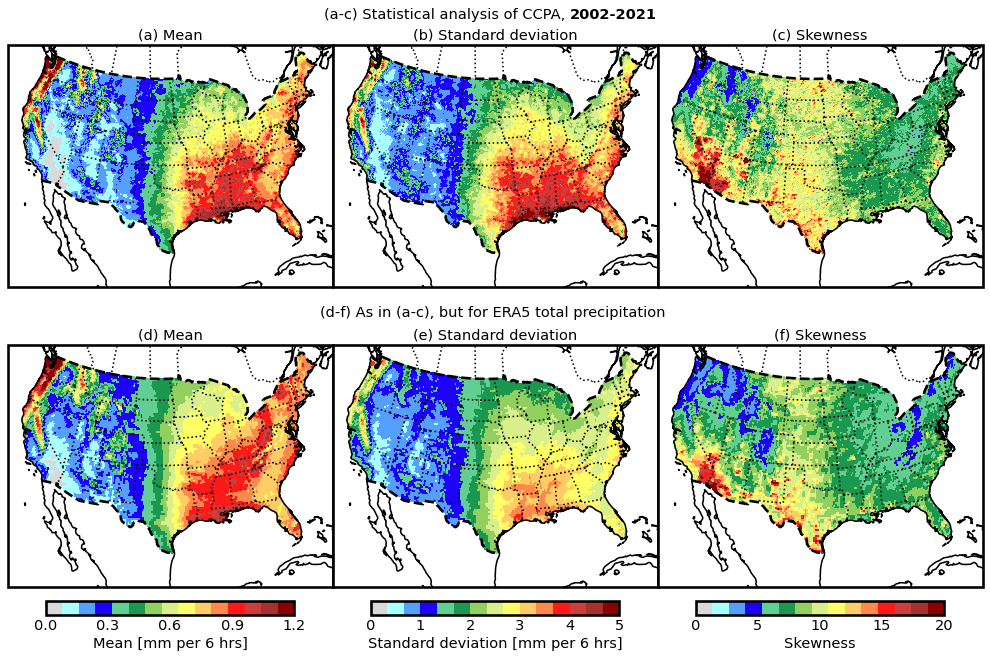

In [9]:
keys = ['mean', 'std', 'skew']
titles = ['(a) Mean', '(b) Standard deviation', '(c) Skewness',
          '(d) Mean', '(e) Standard deviation', '(f) Skewness']

YLIMs = [[0, 1.2], [0, 5], [0, 20]]

edge_ = [-118, -77.5, 22, 51.5] #[-118, -77.5, 25.5, 51.5]

fig = plt.figure(figsize=(13, 8), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

AX = []
AX.append(plt.subplot(gs[0, 0], projection=proj_))
AX.append(plt.subplot(gs[0, 1], projection=proj_))
AX.append(plt.subplot(gs[0, 2], projection=proj_))
AX.append(plt.subplot(gs[1, 0], projection=proj_))
AX.append(plt.subplot(gs[1, 1], projection=proj_))
AX.append(plt.subplot(gs[1, 2], projection=proj_))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for n, ax in enumerate(AX):
    ax.set_extent(edge_, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)

    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.left_labels = False
    GL.bottom_labels = False   
    
    GL.xlocator = mticker.FixedLocator(np.arange(-113, -75, 10))
    GL.ylocator = mticker.FixedLocator(np.arange(26, 52, 6))
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False

CS_list = []
for i_key, key in enumerate(keys):
    AX[i_key].pcolormesh(lon_CCPA, lat_CCPA, ds_CCPA[key].values, 
                         vmin=YLIMs[i_key][0], vmax=YLIMs[i_key][1], 
                         cmap=cmap_pct, transform=ccrs.PlateCarree())
    AX[i_key].set_title(titles[i_key], fontsize=14)

    # ------------------------------------------------------------------ #
    # bottom row
    if i_key in [0, 1]:
        # convert m to mm
        ERA5_plot_var = 1e3*ds_ERA5[key].values[28:140, 221:452]
    else:
        # skewness has no unit
        ERA5_plot_var = ds_ERA5[key].values[28:140, 221:452]
        
    CS = AX[3+i_key].pcolormesh(lon_ERA5[28:140, 221:452], lat_ERA5[28:140, 221:452], ERA5_plot_var, 
                                vmin=YLIMs[i_key][0], vmax=YLIMs[i_key][1], 
                                cmap=cmap_pct, transform=ccrs.PlateCarree())
    CS_list.append(CS)
    AX[3+i_key].set_title(titles[3+i_key], fontsize=14)

pad = 1/20

ax_base = fig.add_axes([0.0+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[0], orientation='horizontal', ticks=[0, 0.3, 0.6, 0.9, 1.2], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('Mean [mm per 6 hrs]', fontsize=14)

ax_base = fig.add_axes([1/3+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[1], orientation='horizontal', cax=cax) #
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('Standard deviation [mm per 6 hrs]', fontsize=14)

ax_base = fig.add_axes([2/3+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[2], orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('Skewness', fontsize=14)

ax_title1 = fig.add_axes([0.5-(0.5*0.35), 0.99, 0.35, 0.025])
gu.string_partial_format(fig, ax_title1, 0.0, 0.98, 'left', 'top', 
                         ['(a-c) Statistical analysis of CCPA, ', '2002-2021'],
                         ['k',]*3, [14,]*3, ['normal', 'bold']);

ax_title2 = fig.add_axes([0.5-(0.5*0.358), 0.493, 0.358, 0.025])
gu.string_partial_format(fig, ax_title2, 0.0, 0.98, 'left', 'top', 
                         ['(d-f) As in (a-c), but for ERA5 total precipitation'],
                         ['k',]*3, [14,]*3, ['normal', 'bold']);

ax_title1.set_axis_off()
ax_title2.set_axis_off()


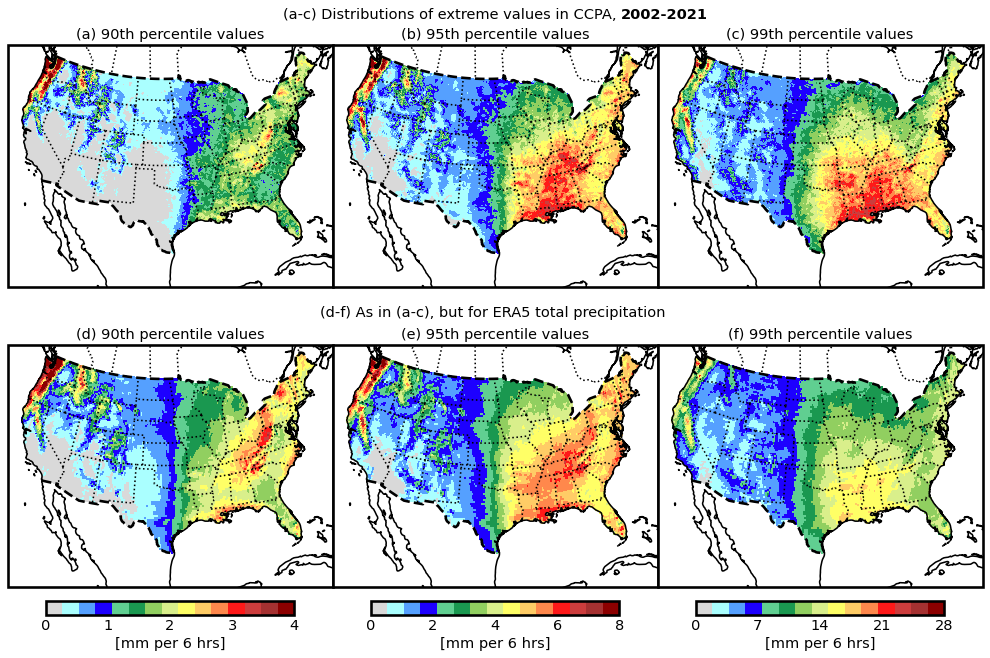

In [10]:
keys = ['q90', 'q95', 'q99']
titles = ['(a) 90th percentile values', '(b) 95th percentile values', '(c) 99th percentile values',
          '(d) 90th percentile values', '(e) 95th percentile values', '(f) 99th percentile values']

YLIMs = [[0, 4], [0, 8], [0, 28]]

edge_ = [-118, -77.5, 22, 51.5] #[-118, -77.5, 25.5, 51.5]

fig = plt.figure(figsize=(13, 8), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

AX = []
AX.append(plt.subplot(gs[0, 0], projection=proj_))
AX.append(plt.subplot(gs[0, 1], projection=proj_))
AX.append(plt.subplot(gs[0, 2], projection=proj_))
AX.append(plt.subplot(gs[1, 0], projection=proj_))
AX.append(plt.subplot(gs[1, 1], projection=proj_))
AX.append(plt.subplot(gs[1, 2], projection=proj_))

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for n, ax in enumerate(AX):
    ax.set_extent(edge_, ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)    
    ax.spines['geo'].set_linewidth(2.5)

    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.left_labels = False
    GL.bottom_labels = False   
    
    GL.xlocator = mticker.FixedLocator(np.arange(-113, -75, 10))
    GL.ylocator = mticker.FixedLocator(np.arange(26, 52, 6))
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False

CS_list = []
for i_key, key in enumerate(keys):
    AX[i_key].pcolormesh(lon_CCPA, lat_CCPA, ds_CCPA[key].values, 
                         vmin=YLIMs[i_key][0], vmax=YLIMs[i_key][1], 
                         cmap=cmap_pct, transform=ccrs.PlateCarree())
    AX[i_key].set_title(titles[i_key], fontsize=14)

    # ------------------------------------------------------------------ #
    # bottom row

    # convert m to mm
    ERA5_plot_var = 1e3*ds_ERA5[key].values[28:140, 221:452]
    CS = AX[3+i_key].pcolormesh(lon_ERA5[28:140, 221:452], lat_ERA5[28:140, 221:452], ERA5_plot_var, 
                                vmin=YLIMs[i_key][0], vmax=YLIMs[i_key][1], 
                                cmap=cmap_pct, transform=ccrs.PlateCarree())
    CS_list.append(CS)
    AX[3+i_key].set_title(titles[3+i_key], fontsize=14)

pad = 1/20

ax_base = fig.add_axes([0.0+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[0], orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('[mm per 6 hrs]', fontsize=14)

ax_base = fig.add_axes([1/3+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[1], orientation='horizontal', cax=cax) #
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('[mm per 6 hrs]', fontsize=14)

ax_base = fig.add_axes([2/3+pad/2, -0.05, 1/3-pad, 0.075])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='90%', borderpad=0, loc=9)
CBar = plt.colorbar(CS_list[2], orientation='horizontal', ticks=[0, 7, 14, 21, 28], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.set_label('[mm per 6 hrs]', fontsize=14)

ax_title1 = fig.add_axes([0.5-(0.5*0.435), 0.99, 0.435, 0.025])
gu.string_partial_format(fig, ax_title1, 0.0, 0.98, 'left', 'top', 
                         ['(a-c) Distributions of extreme values in CCPA, ', '2002-2021'],
                         ['k',]*3, [14,]*3, ['normal', 'bold']);

ax_title2 = fig.add_axes([0.5-(0.5*0.358), 0.493, 0.358, 0.025])
gu.string_partial_format(fig, ax_title2, 0.0, 0.98, 'left', 'top', 
                         ['(d-f) As in (a-c), but for ERA5 total precipitation'],
                         ['k',]*3, [14,]*3, ['normal', 'bold']);

ax_title1.set_axis_off()
ax_title2.set_axis_off()